# Text classification: Understanding the Customer's Feedback

---

Text classification is one of the important tasks of text mining

![alt text](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1535125878/NLTK3_zwbdgg.png)

In this notebook, we will perform Sentiment Analysis on IMDB movies reviews. Sentiment Analysis is the art of extracting people's opinion from digital text. We will use a regression model from Scikit-Learn able to predict the sentiment given a movie review.

We will use [the IMDB movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movies review (50% are positive, 50% are negative).

The libraries needed in this exercise are:
* [Numpy](http://www.numpy.org/) — a package for scientific computing.
* [Pandas](https://pandas.pydata.org/) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
* [Matplotlib](https://matplotlib.org/) — a package for plotting & visualizations.
* [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
* [NLTK](http://www.nltk.org/) — a platform to work with natural language.

##Loading the data

### Importing the libraries and necessary dictionaries

In [3]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from tensorflow import keras

# download Punkt Sentence Tokenizer
nltk.download('punkt')
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading the dataset in our directory

In [2]:
# download IMDB dataset
!wget "https://raw.githubusercontent.com/javaidnabi31/Word-Embeddding-Sentiment-Classification/master/movie_data.csv" -O "movie_data.csv"

# list files in current directory
!ls -lah

--2023-11-16 14:04:55--  https://raw.githubusercontent.com/javaidnabi31/Word-Embeddding-Sentiment-Classification/master/movie_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65862309 (63M) [text/plain]
Saving to: ‘movie_data.csv’

movie_data.csv      100%[===================>]  62.81M   245MB/s    in 0.3s    

2023-11-16 14:04:55 (245 MB/s) - ‘movie_data.csv’ saved [65862309/65862309]

total 63M
drwxr-xr-x 1 root root 4.0K Nov 16 14:04 .
drwxr-xr-x 1 root root 4.0K Nov 16 14:03 ..
drwxr-xr-x 4 root root 4.0K Nov 14 14:22 .config
-rw-r--r-- 1 root root  63M Nov 16 14:04 movie_data.csv
drwxr-xr-x 1 root root 4.0K Nov 14 14:23 sample_data


HANEEN HAMED AL-MABADI
haneenalmabadi@gmail.com

###Reading the dataset file and getting info on it
**Question 1:** Use pandas to read the csv file and display the first 5 rows

In [4]:
# path to IMDB dataseet
dataset_path = 'movie_data.csv'

# read file (dataset) into our program using pandas
data = pd.read_csv('movie_data.csv')

# display first 5 rows
data.head(5)




,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


Getting info on our dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


A balanced dataset in sentiment analysis is a dataset which holds an equal amount of positive sentiment data and negative sentiment data, meaning 50% of the data is positive and 50% is negative

[link text](https://)**Question 2:** Check if dataset is balanced (number of positive sentiment = number of negative sentiment) by plotting the different classes

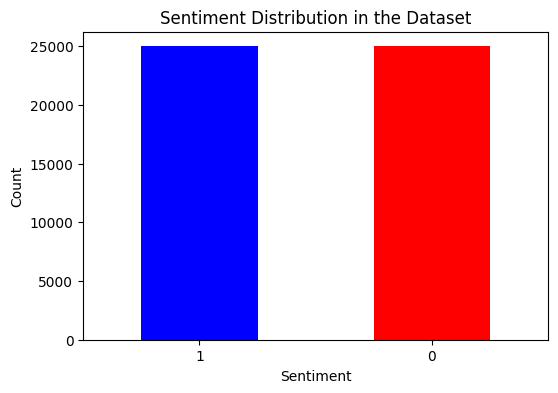

1    25000
0    25000
Name: sentiment, dtype: int64


In [9]:
# Count the number of occurrences for each sentiment class
sentiment_counts =data['sentiment'].value_counts()
# Plotting the sentiment distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Sentiment Distribution in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Display the counts of each sentiment
print(sentiment_counts)


## Text cleaning

In [10]:
print(data.review[10])

I loved this movie from beginning to end.I am a musician and i let drugs get in the way of my some of the things i used to love(skateboarding,drawing) but my friends were always there for me.Music was like my rehab,life support,and my drug.It changed my life.I can totally relate to this movie and i wish there was more i could say.This movie left me speechless to be honest.I just saw it on the Ifc channel.I usually hate having satellite but this was a perk of having satellite.The ifc channel shows some really great movies and without it I never would have found this movie.Im not a big fan of the international films because i find that a lot of the don't do a very good job on translating lines.I mean the obvious language barrier leaves you to just believe thats what they are saying but its not that big of a deal i guess.I almost never got to see this AMAZING movie.Good thing i stayed up for it instead of going to bed..well earlier than usual.lol.I hope you all enjoy the hell of this movi

**Question 3:** Let's define a function that would clean each movie review (sentence)

In [17]:
import re
import bs4
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_review(text):
    # Remove HTML tags
    text = bs4.BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters and digits (optional)
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    stopword_list = stopwords.words('english')
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopword_list]
    text = ' '.join(tokens)

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(lemmatized)

    return text

**Question 4 :** Try it out on an instance of the dataset then on the entire dataset.

In [26]:
# Apply clean_review function to a single review (first review in this case)
sample_review = data['review'].iloc[0]  # Assuming the review column is named 'review'
cleaned_sample_review = clean_review(sample_review)

# Display original and cleaned review
print("Original Review:")
print(sample_review)
print("\nCleaned Review:")
print(cleaned_sample_review)


Original Review:
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

Cleaned Review:
went saw movie last night coaxed friend mine ill admit reluctant see knew ashton kutcher able comedy wrong kutcher played character jake fischer well kevin costner played 

And now clean the entire dataset reviews

In [27]:
# apply to all dataset
data['clean_review'] = data['review'].apply(clean_review)
data.head()

<ipython-input-17-d383d888e3cd>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = bs4.BeautifulSoup(text, "html.parser").get_text()


,review,sentiment,clean_review
0,I went and saw this movie last night after bei...,1,went saw movie last night coaxed friend mine i...
1,Actor turned director Bill Paxton follows up h...,1,actor turned director bill paxton follows prom...
2,As a recreational golfer with some knowledge o...,1,recreational golfer knowledge sport history pl...
3,"I saw this film in a sneak preview, and it is ...",1,saw film sneak preview delightful cinematograp...
4,Bill Paxton has taken the true story of the 19...,1,bill paxton taken true story u golf open made ...


## Split dataset for training and testing
We will split our data into two subsets: a 50% subset will be used for training the model for prediction and the remaining 50% will be used for evaluating or testing its performance. The random state ensures reproducibility of the results.

**Question 5:** Split your data to get x_train, x_test, y_train and y_test.

In [29]:
from sklearn.model_selection import train_test_split

X = data['clean_review']
y = data['sentiment']

# Split data into 50% training & 50% test
# Use a random state of 42 for example to ensure having the same split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25000,) (25000,)
(25000,) (25000,)


## Feature extraction with Bag of Words


**Question 6:**  In this section, apply the Bag of Words method to learn the vocabulary of your text and with it transform your training input data.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# define a CountVectorizer (with binary=True and max_features=10000)
vectorizer = CountVectorizer(binary=True, max_features=10000)

# learn the vocabulary of all tokens in our training dataset
vectorizer.fit(X_train)

# transform x_train to bag of words
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

(25000, 10000) (25000,)
(25000, 10000) (25000,)


## Classification

**Question 7:** Your data is ready for classification. For this task use [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [31]:
from sklearn.linear_model import LogisticRegression

# define the LogisticRegression classifier
model = LogisticRegression(C=0.1)

# train the classifier on the training data
model.fit(X_train_bow, y_train)

# get the mean accuracy on the training data
acc_train = model.score(X_train_bow, y_train)

print('Training Accuracy:', acc_train)

Training Accuracy: 0.94428


**Question 8:**  Evaluating the performance of your model through its accuracy score

In [32]:
# Evaluate model with test data
# Transform the test data to bag of words
X_test_bow = vectorizer.transform(X_test)

# Get the mean accuracy on the test data
acc_test = model.score(X_test_bow, y_test)

print('Test Accuracy:', acc_test)

Test Accuracy: 0.87844


## Bonus: Let's use the model to predict!
To do so, let's create a predict function which takes as argument your model and the bag of words vectorizer together with a review on which it would predict the sentiment. This review should be cleaned with the `clean_review` function we built, transformed by bag of words and then used for prediction with `model.predict()`.

In [33]:
# define predict function
def predict(model, vectorizer, cleaned_review):
    # Transform the cleaned review to bag of words
    review_bow = vectorizer.transform([cleaned_review])

    # Predict the sentiment
    prediction = model.predict(review_bow)

    # Return the predicted sentiment (0 for negative, 1 for positive)
    return prediction[0]

# Example usage:
review = 'The movie was great!'
predicted_sentiment = predict(model, vectorizer, clean_review(review))

print('Predicted Sentiment:', predicted_sentiment)

Predicted Sentiment: 1


And let's try it out on an example

In [34]:
review = 'The movie was great!'
predict(model, vectorizer, review)


1